Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


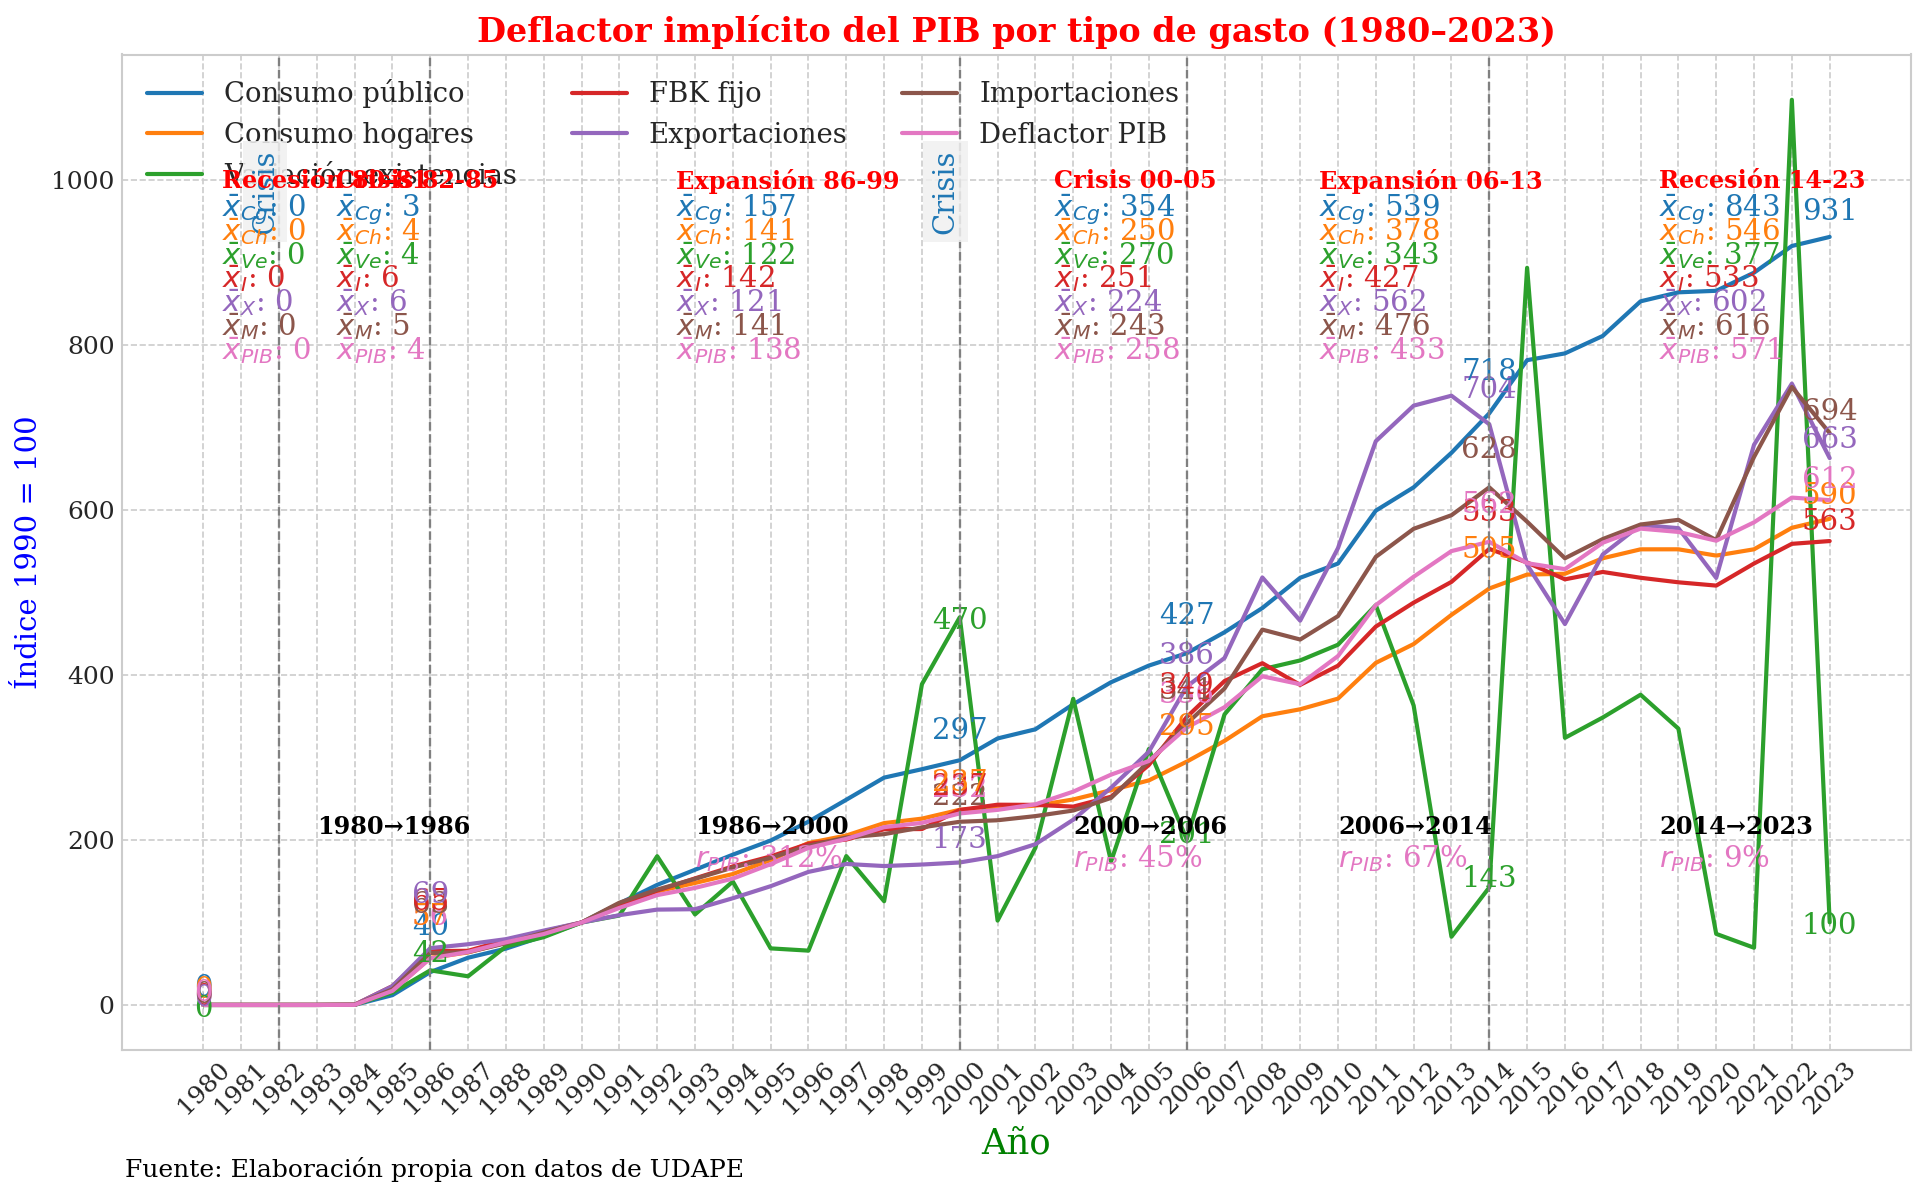

In [1]:
# ── 1. Imports y configuración general ───────────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *

# Directorio de salida
output_dir = "../../../../assets/tesis/serie_completa/deflactor_pib_gasto"
os.makedirs(output_dir, exist_ok=True)
set_style()

# %%
# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (
        pd.read_sql('SELECT * FROM deflactor_implicito_pib_gasto', conn, index_col='año')
          .sort_index()
    )

# %%
# ── 3. Componentes ─────────────────────────────────────────────────--
componentes = [
    ("consumo_publico",        "Consumo público"),
    ("consumo_hogares",        "Consumo hogares"),
    ("variacion_existencias",  "Variación existencias"),
    ("formacion_capital_fijo", "FBK fijo"),
    ("exportaciones",          "Exportaciones"),
    ("importaciones",          "Importaciones"),
    ("pib_precios_mercado",    "Deflactor PIB"),
]
cols_componentes = [c for c, _ in componentes]

abbr = {
    "consumo_publico":        "Cg",
    "consumo_hogares":        "Ch",
    "variacion_existencias":  "Ve",
    "formacion_capital_fijo": "I",
    "exportaciones":          "X",
    "importaciones":          "M",
    "pib_precios_mercado":    "PIB",
}

# Colores (tab10)
cmap = plt.get_cmap('tab10')
custom_colors = {
    "consumo_publico":        cmap(0),
    "consumo_hogares":        cmap(1),
    "variacion_existencias":  cmap(2),
    "formacion_capital_fijo": cmap(3),
    "exportaciones":          cmap(4),
    "importaciones":          cmap(5),
    "pib_precios_mercado":    cmap(6),
}

# %%
# ── 4. Preparación de ciclos y periodos ──────────────────────────────
annot_years = adjust_annot_years(df, annot_years)
cycles       = adjust_cycles(df, CYCLES)
cycle_stats  = {n: df.loc[s, cols_componentes].mean().to_dict()
                for n, s in cycles.items()}
periodos     = adjust_periods(df, periodos_tasas)

# %%
# ── 5. Offsets ───────────────────────────────────────────────────────
# Ajustados rápidamente para que ninguna etiqueta se solape.
annotation_offsets = {
    'pib_precios_mercado': {
        1980: (0,  15),  1986: (0,  50),  2000: (0,  30),
        2006: (0,  40),  2014: (0,  45),  2023: (0,  25),
    },
    'consumo_publico': {
        1980: (0,  20),  1986: (0,  55),  2000: (0,  35),
        2006: (0,  45),  2014: (0,  50),  2023: (0,  30),
    },
    'consumo_hogares': {
        1980: (0,  18),  1986: (0,  50),  2000: (0,  32),
        2006: (0,  42),  2014: (0,  47),  2023: (0,  28),
    },
    'formacion_capital_fijo': {
        1980: (0,  10),  1986: (0,  60),  2000: (0,  28),
        2006: (0,  38),  2014: (0,  43),  2023: (0,  23),
    },
    'exportaciones': {
        1980: (0,   8),  1986: (0,  65),  2000: (0,  27),
        2006: (0,  37),  2014: (0,  42),  2023: (0,  22),
    },
    'importaciones': {
        1980: (0,  12),  1986: (0,  58),  2000: (0,  30),
        2006: (0,  40),  2014: (0,  45),  2023: (0,  25),
    },
    'variacion_existencias': {
        1980: (0,  -5), 1986: (0,  20),  2000: (0,  -5),
        2006: (0,   5), 2014: (0,  10),  2023: (0,  -5),
    },
}

# Líneas verticales de hitos
hitos_offset = {a: 0.9 for a in hitos_v if a >= df.index.min()}

# Medias de ciclo (posicionadas cerca de la parte superior)
medias_offsets = {
    k: (slice_.start + (slice_.stop - slice_.start)/2, 0.88)
    for k, slice_ in cycles.items()
}

# Tasas de crecimiento (solo para el deflactor PIB)
tasas_offsets = {
    f"{vi}-{vf}": (vi + (vf-vi)/2, 0.2)
    for vi, vf in periodos
}

# %%
# ── 6. Gráfica ───────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"Deflactor implícito del PIB por tipo de gasto ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Índice 1990 = 100",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)

# Hitos
add_hitos(ax, df.index, hitos_v, hitos_offset)

# Anotaciones de valores
add_year_value_annotations(
    ax, df,
    years=annot_years,
    columnas=cols_componentes,
    annotation_offsets=annotation_offsets,
    colors=custom_colors,
    arrow_lw=0.2,
)

# Medias por ciclo
line_spacing = ax.get_ylim()[1] * 0.025
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr_map=abbr, colors=custom_colors,
    line_spacing=line_spacing,
)

# Tasas de crecimiento (solo Deflactor PIB)
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['pib_precios_mercado'],
    period_offsets=tasas_offsets,
    colors=custom_colors,
    abbr_map={'pib_precios_mercado': 'PIB'},
)

#plt.savefig(os.path.join(output_dir, "deflactor_implicito_pib_gasto.png"))
plt.show()
